# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

SEED = 2024

# Data preparation

In [2]:
data = pd.read_csv('/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv')

In [3]:
TARGET = 'CourseCompletion'
features = [f for f in data.columns if f not in ('UserID', TARGET)]
cat_features = ['DeviceType', 'CourseCategory']
num_features = [f for f in features if f not in cat_features]

### Preprocessing
**Source**: [Online Course Engagement - Comprehensive EDA](https://www.kaggle.com/code/sid4ds/online-course-engagement-comprehensive-eda/notebook)

In [4]:
def preprocess_dataset(df):
    # remove duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # one-hot encoding nominal variable
    df = pd.get_dummies(df, columns=['CourseCategory'], dtype='int8')
    
    df['DeviceType'] = df['DeviceType'].astype('int8')
    
    # binarize numerical features
    df['time_spent_above_threshold'] = (df['TimeSpentOnCourse'] > 20).astype('int8')
    df['num_videos_above_threshold'] = (df['NumberOfVideosWatched'] > 5).astype('int8')
    df['num_quizzes_above_threshold'] = (df['NumberOfQuizzesTaken'] > 3).astype('int8')
    df['quiz_scores_above_threshold'] = (df['QuizScores'] > 68).astype('int8')
    df['completion_above_threshold'] = (df['CompletionRate'] > 60).astype('int8')
    
    return df

In [5]:
data = preprocess_dataset(data.copy())

### Feature sets

In [6]:
extended_features = [f for f in data.columns if f not in ('UserID', TARGET)]
original_features = [f for f in extended_features if not f.endswith('threshold')]
binary_features = [f for f in extended_features if f not in num_features]
minimal_features = [f for f in extended_features if f.endswith('threshold')]

In [7]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Binary': binary_features,
    'Minimal': minimal_features
}

In [8]:
for fname, fset in feature_sets.items():
    print(f'{fname}: {fset}\n')

Original: ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 'CourseCategory_Health', 'CourseCategory_Programming', 'CourseCategory_Science']

Extended: ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 'CourseCategory_Health', 'CourseCategory_Programming', 'CourseCategory_Science', 'time_spent_above_threshold', 'num_videos_above_threshold', 'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 'completion_above_threshold']

Binary: ['DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 'CourseCategory_Health', 'CourseCategory_Programming', 'CourseCategory_Science', 'time_spent_above_threshold', 'num_videos_above_threshold', 'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 'completion_above_threshold']

Minimal: ['time_spent_a

### Holdout set for model-testing
(10% of the dataset)

In [9]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.1,
    shuffle=True,
    random_state=SEED
)

# Modeling framework

In [10]:
def cross_validate(estimator, feature_set, num_folds=9):
    global train, TARGET
    
    scores_auc, scores_acc = [], []
    X, y = train[feature_set], train[TARGET]
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]
        scores_auc.append(roc_auc_score(y_val, probs))
        preds = model.predict(X_val)
        scores_acc.append(accuracy_score(y_val, preds))
        
    scores_df = pd.DataFrame(
        data={'Accuracy': scores_acc, 'ROC-AUC': scores_auc}, 
        index=[f'Fold #{i+1}' for i in range(9)]
    )
    display(scores_df.T)

In [11]:
def refit_full_and_evaluate(model, feature_set):
    global train, TARGET
    
    model.fit(train[feature_set], train[TARGET])
    probs = model.predict_proba(test[feature_set])[:, 1]
    preds = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], preds)
    auc = roc_auc_score(test[TARGET], probs)
    print(f'|| Accuracy: {accuracy:.4f} || ROC-AUC: {auc:.4f} ||\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], preds, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    
    return model

In [12]:
def save_model(model, config, notebook='01'):
    save_path = f'{notebook}_{config}.joblib'
    joblib.dump(model, save_path)

In [13]:
def run_experiment(estimator, model_name, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*25, fname, '-'*25)
        start_time = time.time()
        print('Cross-validation:')
        cross_validate(estimator, fset)
        print('Refit to full training data and evaluate:\n')
        model = refit_full_and_evaluate(estimator, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_model(model, f'{model_name}_{fname}')

# Baseline model: Logistic Regression

In [14]:
estimator = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty=None, random_state=SEED)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.7774,0.7970,0.7980,0.7894,0.7808,0.7820,0.8054,0.7943,0.8153
ROC-AUC,0.8568,0.8584,0.8686,0.8703,0.8580,0.8578,0.8858,0.8720,0.8921


Refit to full training data and evaluate:

|| Accuracy: 0.7835 || ROC-AUC: 0.8666 ||



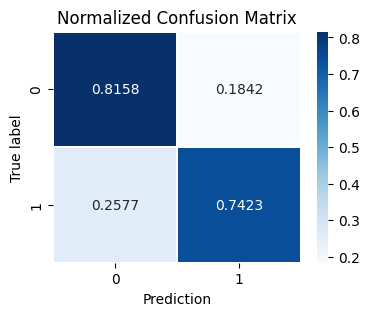


(Time taken: 0.81 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9583,0.9422,0.9494,0.9477,0.9531,0.9429,0.9536,0.9632,0.9679


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9630 ||



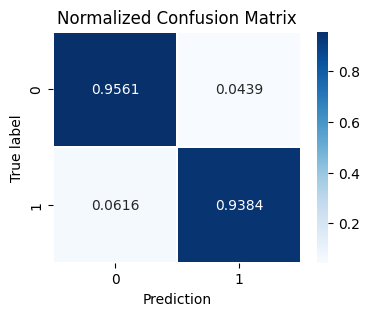


(Time taken: 0.93 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9473,0.9337,0.9392,0.9421,0.9514,0.9369,0.9429,0.9574,0.9584


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9553 ||



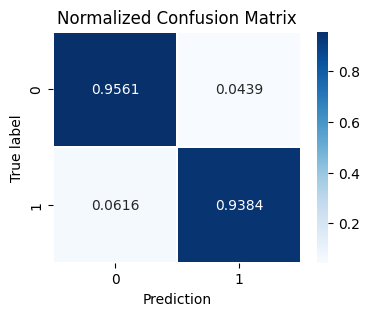


(Time taken: 0.76 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9465,0.9311,0.9403,0.9446,0.9501,0.9368,0.9472,0.9566,0.9579


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9545 ||



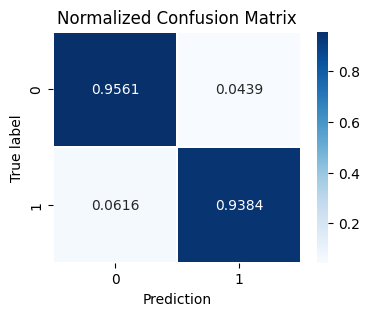


(Time taken: 0.68 secs)


In [15]:
run_experiment(estimator, 'logreg')

# Summary

* Created four feature sets based on previous EDA: Original, Extended, Binary, Minimal
* Evaluated their performance using a simple model as baseline: Logistic Regression 
* Significant increase in accuracy between Original to Extended feature sets.  
  This confirms that our engineered features are important.
* Exactly the same accuracy for Extended, Binary and Minimal feature sets.  
  Training time is reduced for fewer features (Minimal) but ROC-AUC improves slightly for more features (Extended).
* If accurate predictions are enough, we should go with the Minimal feature set to reduce training time.  
  If we need better probabilities at the cost of more training time, we should go with the Extended feature set.